In [1]:
## import the necessary libraries

import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt, font_manager as fm
from skimage.measure import profile_line
from skimage.feature import peak_local_max, shape_index, canny
from skimage.morphology import disk
from skimage.filters import roberts, sobel, median
import tifffile as tf
from scipy.signal import find_peaks
from scipy.ndimage import rotate, center_of_mass
#!{sys.executable} -m pip install matplotlib
from photutils.aperture import CircularAnnulus, CircularAperture, aperture_photometry
from matplotlib import cm

In [2]:
def align_to_velocity(i, pixsc, trackID, timepoint, velocities, xy_pos, img, ain, aout, filename, savefolder):
    specific_trackID = trackID.values[i][0]
    specific_vel = velocities[velocities['Time'] == timepoint]
    specific_v = specific_vel[['Velocity Angle X', 'Velocity Angle Y']][specific_vel['TrackID'] == specific_trackID]
    specific_vx, specific_vy = specific_v.values[0]

    x, y = xy_pos.values[i]/pixsc
    aper = CircularAnnulus([int(np.round(x)), int(np.round(y))], ain, aout)
    mask = aper.to_mask(method = 'exact')
    raw_data = mask.multiply(img[timepoint - 1, :, :])

    #fig, ax = plt.subplots()
    #ax.imshow(raw_data)
    tif_savename = filename + '_track_' + str(specific_trackID) + '_timepoint_' + str(timepoint) + '.tif'
    #plt.savefig(os.path.join(savefolder, svg_savename), format = 'svg')
    tf.imwrite(os.path.join(savefolder, tif_savename), raw_data)
    #plt.close()
    #print(specific_v.values)
    ## rotate data to align the velocity to north
    if specific_vy > 90:
        rot_angle = -specific_vx
        rot_data = rotate(raw_data, angle = rot_angle, reshape = False)
    if specific_vy < 90:
        rot_angle = specific_vx
        rot_data = rotate(raw_data, angle = rot_angle, reshape = False)
    return rot_data, rot_angle, specific_trackID

In [3]:
def cart2pol(x, y):
    xx, yy = np.meshgrid(x,y)
    r = np.sqrt(xx**2 + yy**2)
    theta = np.arctan2(yy, xx)
    
    return r, theta

In [4]:
## read in the green fluorescent image and xls positions and velocity files
#def read_files(imgfile, xlspos, xlsvel):
#    img = tf.imread(imgfile)[:, 1, :, :]
#    positions = pd.read_excel(xlspos, header = 1)
#    velocities = pd.read_excel(xlsvel, header = 3)  
#    return img, positions, velocities

In [5]:
## read in the green fluorescent image and xls positions and velocity files
def read_files(imgfile, xlsfile):
    img = tf.imread(imgfile)[:, 1, :, :]
    positions = pd.read_excel(xlsfile, header = 1, sheet_name = 'Position')
    velocity_angles = pd.read_excel(xlsfile, header = 1, sheet_name = 'Velocity Angle')  
    return img, positions, velocity_angles

In [6]:
def polar_chunk(theta, dtheta, n, rho):
    ## this works for 0 - pi
    posind = np.where((theta <= dtheta*(n + 1)) & (theta > n*dtheta) & (rho <= aout))
    ## this for pi - 2pi since we have negative thetas
    negind = np.where((theta > -dtheta*(n + 1)) & (theta <= -n*dtheta) & (rho <= aout))
    ## try playing with inequality to see if the distribution shifts
    ## <= goes to < and > goes to >=
    
    ## this works for 0 - pi
    #posind = np.where((theta < dtheta*(n + 1)) & (theta >= n*dtheta))
    ## this for pi - 2pi since we have negative thetas
    #negind = np.where((theta >= -dtheta*n) & (theta < -(n+1)*dtheta))
    
    #print(len(posind[0]), len(negind[0]))
    #fig1, ax1 = plt.subplots(subplot_kw={'projection': 'polar'})
    #ax1.plot(theta[posind], rho[posind], '.')
    #ax1.plot(theta[negind], rho[negind], '.')
    #plt.show()
    return posind, negind

In [7]:
## parse the xls file and sort according to the timepoint (one point at the moment) and organize by trackID
def sort_xls(positions, timepoint):
    sorted_positions = positions.sort_values('TrackID')
    #sorted_x = sorted_positions.iloc[:, 0]
    #sorted_y = sorted_positions.iloc[:, 1]
    #sorted_time = sorted_positions.iloc[:, 6]
    #sorted_trackids = sorted_positions.iloc[:, 7]
    #unique_trackids = set(sorted_trackids.values)
    xy_pos = sorted_positions[['Position X', 'Position Y']][sorted_positions['Time'] == timepoint]
    trackID = sorted_positions[['TrackID']][sorted_positions['Time'] == timepoint]
    return trackID, xy_pos

In [8]:
def polar_average(aout, ang_size, rot_data_i, ntheta):

    nx, ny = aout, aout 
    x = np.linspace(-nx, nx, 2*nx + 1)
    y = np.linspace(-ny, ny, 2*ny + 1)
    #dtheta = ang_size*np.pi/180
    #ntheta = np.pi/dtheta
    r, theta = cart2pol(x, y)

    int_dict = {'intensity': [], 'angle': []}
    ## sanity check the indices
    for n in range(int(ntheta)):
        posind, negind = polar_chunk(theta, dtheta, n, r)
        #int_dict['intensity'].append(np.sum(rot_data_i[posind]))
        #int_dict['intensity'].append(np.sum(rot_data_i[negind]))
        int_dict['intensity'].append(np.mean(rot_data_i[posind]))
        int_dict['intensity'].append(np.mean(rot_data_i[negind]))
        
        
        ## offset by 0.5 so that the data lie in the center of the angle
        int_dict['angle'].append(dtheta*(n + 0.5))
        int_dict['angle'].append(-dtheta*(n + 0.5))
    return int_dict, dtheta

In [16]:
def plot_polar(angles, intensities, dtheta, std_polar_int, filename, timepoint, savefolder):
    int_mean = np.mean(intensities)

    rlim = 3.6e6/11.707/80
    fig, ax = plt.subplots(subplot_kw = {'projection': 'polar'})
    ax.bar(angles, 
           intensities, 
           alpha = 1, 
           width = dtheta, 
           color = 'limegreen', 
           edgecolor = 'black', 
           zorder = 3)
    ax.errorbar(angles, 
                intensities, 
                yerr = std_polar_int, 
                fmt = '.', 
                color = 'k', 
                markersize = 0,
                elinewidth = 1,
                zorder = 4)
    ax.arrow(0, 
                    rlim/2, 
                    0, 
                    rlim*1.2, 
                    alpha = 1, 
                    width = 0.05,
                    edgecolor = 'black', 
                    facecolor = 'black', 
                    lw = 1, 
                    head_width = 0,
                    zorder = 3)

    ax.set_theta_offset(np.pi / 2.0)
    ax.set_yticklabels([])
    ax.set_ylim([0, rlim])
    #ax.set_title('Radial Intensity Distribution',
    #        fontproperties=fprop, size=20, fontweight="bold")
    plt.grid('off')

    plt.show()
    
    svg_savename = filename + '_timepoint_' + str(timepoint) + '_angular_intensity_distribution.pdf'
    print(svg_savename, savefolder)
    plt.savefig(os.path.join(savefolder, svg_savename), format = 'pdf')
    plt.close()

In [10]:
## define the CONSTANTS: image and xls paths, pixel scale, timepoint(s)

imgfoldername = 'images'
xlsfoldername = 'excel'


#imgfile = 'WT_0.5BSA_03_P2.tif'
#filename = os.path.splitext(imgfile)[0]
#xlspos = 'WT_0.5BSA_03_P2_position.xls'
#xlsvel = 'Velocity Angle.xlsx'
#xlsfile = 'excel/WT_0.5BSA_03_P2_all.xlsx'

## um/pixel
pixsc = 0.3230005

## font parameters
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.rcParams['pdf.fonttype'] = 42
#fprop = fm.FontProperties(fname='to-the-po.ttf')

## time index starts at 1 not 0
start_t = 4
stop_t = 6

## using the single time point at the moment
timepoints = np.arange(start_t, stop_t + 1)

## annulus sizes
ain, aout = 4, 15

## angular chunk size in degrees
ang_size = 30
num_chunks = 360//30

dtheta = ang_size*np.pi/180
ntheta = np.pi/dtheta

Analyzing Image: WT_0.5BSA_new glass_02_P5_mod.tif
found matching excel file: WT_0.5BSA_new glass_02_P5_all.xlsx


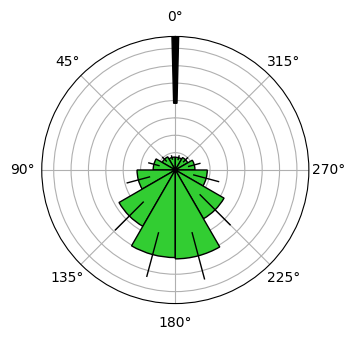

WT_0.5BSA_new glass_02_P5_mod_timepoint_4_angular_intensity_distribution.pdf images/WT_0.5BSA_new glass_02_P5_mod


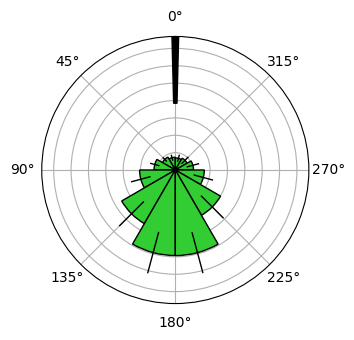

WT_0.5BSA_new glass_02_P5_mod_timepoint_5_angular_intensity_distribution.pdf images/WT_0.5BSA_new glass_02_P5_mod


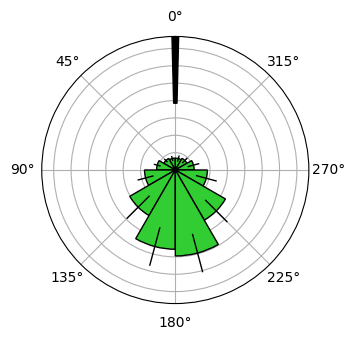

WT_0.5BSA_new glass_02_P5_mod_timepoint_6_angular_intensity_distribution.pdf images/WT_0.5BSA_new glass_02_P5_mod


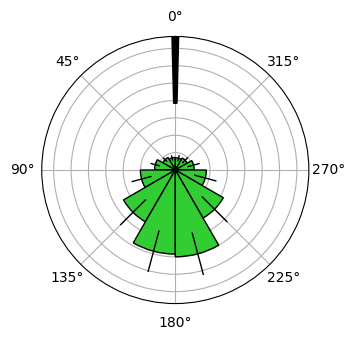

WT_0.5BSA_new glass_02_P5_mod_avg_over_time_timepoint_4to6_angular_intensity_distribution.pdf images/WT_0.5BSA_new glass_02_P5_mod
Analyzing Image: WT_0.5BSA_new glass_02_P3_mod.tif
found matching excel file: WT_0.5BSA_new glass_02_P3_all.xlsx


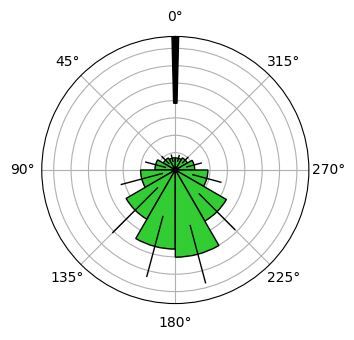

WT_0.5BSA_new glass_02_P3_mod_timepoint_4_angular_intensity_distribution.pdf images/WT_0.5BSA_new glass_02_P3_mod


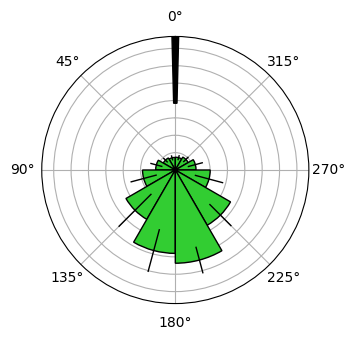

WT_0.5BSA_new glass_02_P3_mod_timepoint_5_angular_intensity_distribution.pdf images/WT_0.5BSA_new glass_02_P3_mod


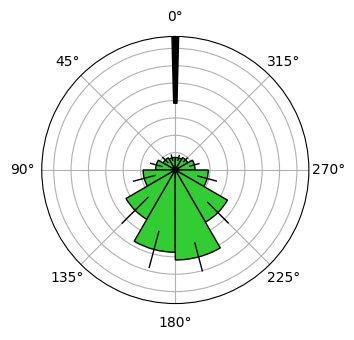

WT_0.5BSA_new glass_02_P3_mod_timepoint_6_angular_intensity_distribution.pdf images/WT_0.5BSA_new glass_02_P3_mod


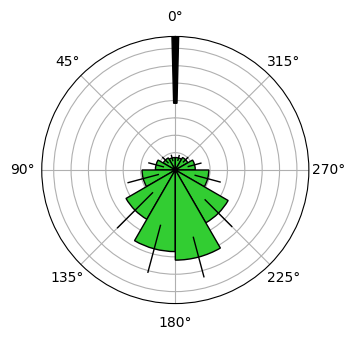

WT_0.5BSA_new glass_02_P3_mod_avg_over_time_timepoint_4to6_angular_intensity_distribution.pdf images/WT_0.5BSA_new glass_02_P3_mod
Analyzing Image: WT_0.5BSA_new glass_02_P1_mod.tif
found matching excel file: WT_0.5BSA_new glass_02_P1_all.xlsx


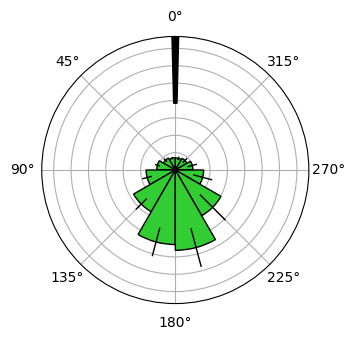

WT_0.5BSA_new glass_02_P1_mod_timepoint_4_angular_intensity_distribution.pdf images/WT_0.5BSA_new glass_02_P1_mod


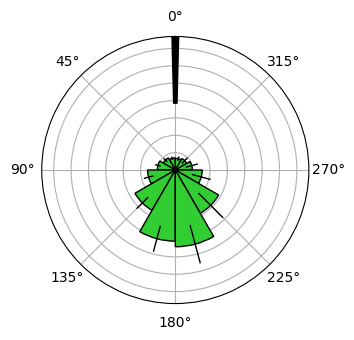

WT_0.5BSA_new glass_02_P1_mod_timepoint_5_angular_intensity_distribution.pdf images/WT_0.5BSA_new glass_02_P1_mod


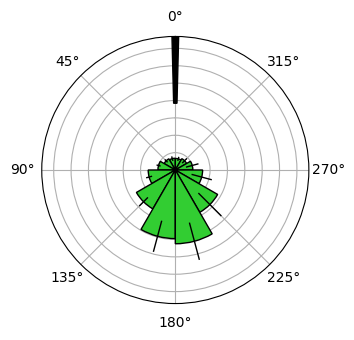

WT_0.5BSA_new glass_02_P1_mod_timepoint_6_angular_intensity_distribution.pdf images/WT_0.5BSA_new glass_02_P1_mod


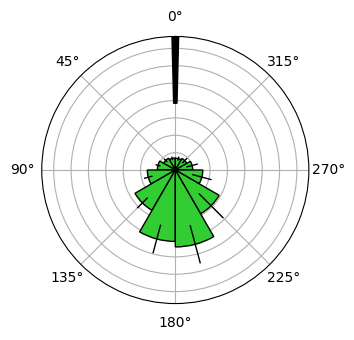

WT_0.5BSA_new glass_02_P1_mod_avg_over_time_timepoint_4to6_angular_intensity_distribution.pdf images/WT_0.5BSA_new glass_02_P1_mod


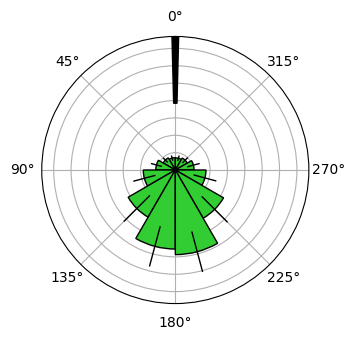

all_images_timepoint_4to6_angular_intensity_distribution.pdf images
Finished!


In [17]:
all_avg_polar_int = 0
all_std_polar_int = 0

## list of image and xls files
imgfolder = os.listdir(imgfoldername)
xlsfolder = os.listdir(xlsfoldername)

with open(os.path.join(imgfoldername, 'polarization_stats.csv'), 'w') as f:
    f.write('Image Name, TrackID, Time Point, Angle (degrees), Sum Intensity\n')
    nimgs = 0
    for i in range(len(imgfolder)):
        avg_avg_polar_int = 0
        avg_std_polar_int = 0
        if not imgfolder[i]. startswith('.') and imgfolder[i].endswith('.tif'):
            imgfile = imgfolder[i]
        #elif imgfolder[i].endswith('.tif'):
        #    imgfile = imgfolder[i]
            print('Analyzing Image:', imgfile)
            nimgs += 1
        else:
            continue

        filename = imgfile[:-4]

        ## check that the save folder exists if not create one with the name of the img file
        savefolderpath = os.path.join(imgfoldername, filename)
        if not os.path.exists(savefolderpath):
            os.mkdir(savefolderpath)
            savefolder = savefolderpath
        else:
            savefolder = savefolderpath

        xlsfile = ''    
        for j in range(len(xlsfolder)):
            if os.path.splitext(imgfile)[0][:-4] == os.path.splitext(xlsfolder[j])[0][:-4]:
                print('found matching excel file:', xlsfolder[j])
                xlsfile = xlsfolder[j]
            else:
                continue
        
        if not xlsfile:
            print('No matching excel file found: exiting')
            exit()
        
        imgfile = os.path.join(imgfoldername, imgfile)
        xlsfile = os.path.join(xlsfoldername, xlsfile)

        for timepoint in timepoints:
            ## read in the files
            img, positions, velocity_angles = read_files(imgfile, xlsfile)

            ## parse the trackID with the bead positions
            trackID, xy_pos = sort_xls(positions, timepoint)
            num_tracks = len(xy_pos.values)
            total_int = []
            all_rot_angle = []

            ## the last track is wonky and maybe should be thrown out (add -1 to num tracks in for)
            for i in range(num_tracks):
                rot_data, rot_angle, specific_trackID = align_to_velocity(i, 
                                                        pixsc, 
                                                        trackID, 
                                                        timepoint, 
                                                        velocity_angles, 
                                                        xy_pos, 
                                                        img, 
                                                        ain , 
                                                        aout, 
                                                        filename, 
                                                        savefolder)
                #if np.sum(rot_data) < 2e5:
                #    print('Low intensity bead found, skipping track, timepoint:', specific_trackID, timepoint)
                #    continue
                #else:
                all_rot_angle.append(rot_angle)
                int_dict, dtheta = polar_average(aout, ang_size, rot_data, ntheta)
                total_int.append(int_dict['intensity'])
                
                for i in range(len(int_dict['intensity'])):
                    f.write(imgfile + ',' + str(specific_trackID) + ',' + str(timepoint) + ',' + str(180/np.pi*int_dict['angle'][i]) + ',' + str(int_dict['intensity'][i]) + '\n' )
                
            total_int = np.array(total_int)
            
            
            avg_polar_int = np.mean(total_int, axis = 0)
            std_polar_int = np.std(total_int, axis = 0)
            std_v = np.std(all_rot_angle)

            plot_polar(int_dict['angle'], 
                       avg_polar_int, 
                       dtheta, 
                       std_polar_int, 
                       filename, 
                       timepoint,
                       savefolder)

            avg_avg_polar_int += avg_polar_int
            avg_std_polar_int += std_polar_int*std_polar_int
            all_std_polar_int += std_polar_int*std_polar_int

        ## just to add all the time points into the filename
        ts = ''.join(str(x) for x in timepoints)
        ts = ts.replace('', '_')
        timerange = str(timepoints[0]) + 'to' + str(timepoints[-1])

        ## plot the polar distibiution averaged over the timpoints, the std is added in quadrature
        plot_polar(int_dict['angle'], 
                   avg_avg_polar_int/len(timepoints), 
                   dtheta, 
                   np.sqrt(avg_std_polar_int/len(timepoints)), 
                   filename + '_avg_over_time', 
                   timerange,
                   savefolder)

        all_avg_polar_int += avg_avg_polar_int

    plot_polar(int_dict['angle'],
               all_avg_polar_int/nimgs/len(timepoints),
               dtheta, 
               np.sqrt(all_std_polar_int/nimgs/len(timepoints)),
               'all_images',
               timerange,
               imgfoldername)

print('Finished!')